### Import libraries

In [108]:
from matplotlib import pyplot as plt
import matplotlib
import pandas as pd
import numpy as np
from matplotlib.offsetbox import AnchoredText
from matplotlib.patches import Rectangle
import math
from IPython.display import display, Markdown, HTML
from scipy import stats
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)
from matplotlib.lines import Line2D

### Load the data

In [109]:
driving_data_file_path = "../data-cleanup/merged-cleaned-csv/driving_data_merged_1_to_49.csv"
driving_data_original = pd.read_csv(driving_data_file_path)

### Exclude participants who do not meet the requirements

In [110]:
# If we want to exclude participants, do it here by their ID
guess_excluded = [5,27,29]
diff_excluded = [10,14,16]
control_excluded = [34,42,45]

exclusion_list = guess_excluded + diff_excluded + control_excluded
#exclusion_list = []

# Remove all rows which are of participants who are in the exclusion_list
# .copy() is important to avoid warnings later, if .copy() not used and we modify driving_data, driving_data_original will be affected too!
driving_data = driving_data_original[~driving_data_original.user_id.isin(exclusion_list)].copy()

# Convert throttle position from [0,1] to [0,100]
driving_data["throttle_position"] *= 100

### Number of participants

In [111]:
# Total number of participants
total_number_of_participants = len(driving_data.user_id.unique())

# Get a df with all unique ids and count the number of users in each group
unique_ids = driving_data.groupby(["evis_id", "user_id"], as_index=False).count() 
number_of_participants_diff = len(unique_ids[unique_ids["evis_id"] == "diff_and_cope1"])
number_of_participants_guess = len(unique_ids[unique_ids["evis_id"] == "guess_o_meter"])
number_of_participants_control = len(unique_ids[unique_ids["evis_id"] == "control_group"])

number_of_participants = pd.DataFrame(data={
    "diff_and_cope1":[number_of_participants_diff], 
    "guess_o_meter":[number_of_participants_guess], 
    "control_group":[number_of_participants_control],
    "total": [sum([number_of_participants_control, number_of_participants_diff, number_of_participants_guess])]}, 
    index=["N"])

number_of_participants

,diff_and_cope1,guess_o_meter,control_group,total
N,13,14,13,40


### Fail/succeed ratios

In [112]:
# Group based on attempt, evis and user id.
each_user = driving_data.groupby(["attempt", "evis_id","user_id"], as_index=False)

# Create a new df with the last datapoint for each attempt
each_user_final_data = each_user.tail(1)

# See it as successful if they are less than 2m from the target. On half car length
successful_distance = 7998

failed_attempts = each_user_final_data[each_user_final_data.distance_traveled < successful_distance]
successful_attempts = each_user_final_data[each_user_final_data.distance_traveled >= successful_distance]

successrate_df = successful_attempts.groupby(["attempt", "evis_id"]).count()[["user_id", "timestamp"]]
successrate_df["timestamp"] = failed_attempts.groupby(["attempt", "evis_id"]).count()
successrate_df = successrate_df.rename(columns={
  "user_id": "successful",
  "timestamp": "failed"
})

successrate_df["failed"] = successrate_df["failed"].apply(lambda x: 0 if math.isnan(x) else int(x))

successrate_df["success rate %"] = successrate_df.apply(lambda x: x["successful"]/(x["successful"]+x["failed"])*100, axis=1)
successrate_df["success rate %"] = successrate_df["success rate %"].round(1)
successrate_df["N"] = successrate_df.apply(lambda x: x["successful"] + x["failed"], axis=1)
successrate_df["N"] = successrate_df["N"].apply(lambda x: int(x))

successrate_df

successful  failed  success rate %   N
attempt evis_id                                               
1       control_group            6       7            46.2  13
        diff_and_cope1           7       6            53.8  13
        guess_o_meter            3      11            21.4  14
2       control_group           11       2            84.6  13
        diff_and_cope1          12       1            92.3  13
        guess_o_meter            9       5            64.3  14

### Assign a distance window for each row

In [113]:
failed_attempts = each_user_final_data[each_user_final_data.distance_traveled < successful_distance]
failed_attempts[(failed_attempts.evis_id == "diff_and_cope1") & (failed_attempts.attempt == 1)]

,attempt,user_id,evis_id,timestamp,current_soc,energy_consumed,power_usage,range_estimate,speed,distance_traveled,throttle_position,break_position,wheel_rot,xPosition,road_elevation,zPosition,tripMeter,odoMeter
13359,1,2,diff_and_cope1,346.384857,0.000012,1.201549,22.636137,-1.0,122.361229,4763.67700,100.001526,0.0,-0.007843,508.599731,4.237413,-1499.11731,NaN,NaN
35100,1,4,diff_and_cope1,391.501648,0.000222,1.207272,38.043343,-1.0,99.250694,5606.93300,92.579424,0.0,0.006470,1102.354610,7.273164,-2083.62085,NaN,NaN
230175,1,22,diff_and_cope1,584.417200,0.002492,1.217025,51.550884,-1.0,49.947285,7036.81000,100.001526,0.0,-0.016175,1014.374820,8.510126,-3300.49561,NaN,NaN
276112,1,26,diff_and_cope1,516.482361,0.000275,1.215078,10.384298,-1.0,52.321160,5930.03174,67.969300,0.0,-0.012177,1291.528690,11.721022,-2344.63800,NaN,NaN
300151,1,28,diff_and_cope1,633.553800,0.001174,1.212231,68.816020,-1.0,71.346060,7990.32300,100.001526,0.0,-0.005402,389.280060,-5.529779,-4005.23300,NaN,NaN
340557,1,32,diff_and_cope1,537.083400,0.000316,1.219586,21.357681,-1.0,50.431090,6515.74170,76.172674,0.0,0.014313,1359.870360,14.443538,-2909.90283,NaN,NaN


In [131]:
# Decide which distance interval to average over
distance_window_size = 50 # in meters

# Calculate which distance window the row should belong to
def assignDistanceWindow(distance):
    #distance_window_index = math.floor(distance / distance_window_size)
    distance_window_index = round(distance / distance_window_size)
    return distance_window_size * distance_window_index

# Add a new column which stores the distance window the distance traveled fits in
driving_data["distance_window"] = driving_data["distance_traveled"].apply(assignDistanceWindow)

# The range estimate seen by the driver using the guess-o-meter & control group is truncated
driving_data["seen_range_estimate"] = driving_data["range_estimate"].apply(lambda x: int(x))

In [132]:
## Calculate mean and STD

## If we want to exclude the failed attempts when calculating mean and STD
exclude_failed_attempts = False
if exclude_failed_attempts:
  for index, row in failed_attempts.iterrows():
    id = row.user_id
    attempt = row.attempt
    driving_data = driving_data[~((driving_data.user_id == id) & (driving_data.attempt == attempt))]

# Get the average and std of each distance window for each user in each drivign attempt
average_individual = driving_data.groupby(["attempt", "evis_id", "user_id", "distance_window"], as_index=False).mean()
std_individual = driving_data.groupby(["attempt", "evis_id", "user_id", "distance_window"], as_index=False).std()

# Get the mean and std for each attempt in each group
average_groups = average_individual.groupby(["attempt", "evis_id", "distance_window"], as_index=False).mean()
std_groups = average_individual.groupby(["attempt", "evis_id", "distance_window"], as_index=False).std()

# Get the average road height for each distance window
road_elevation = average_groups[["distance_window", "road_elevation"]]
road_elevation = road_elevation.groupby(["distance_window"], as_index=False).mean()

# Plot group averages

In [133]:
variables_print_pretty = {
  "diff_and_cope1": "Diff & COPE1",
  "guess_o_meter": "Guess-o-meter",
  "control_group": "Control group",
  "speed": "Speed",
  "power_usage": "Power",
  "throttle_position": "Throttle",
  "current_soc": "State of charge"
}
variables_unit = {
  "speed": "[km/h]",
  "power_usage": "[kW]",
  "throttle_position": "[%]",
  "current_soc": "[kWh]"
}
matplot_params = {
    'font.size': 12,
    'axes.labelsize': 15,
    'axes.titlesize': 15,
    'legend.fontsize': 10,
    'xtick.labelsize': 15,
    'ytick.labelsize': 15
}
matplotlib.rcParams.update(matplot_params)

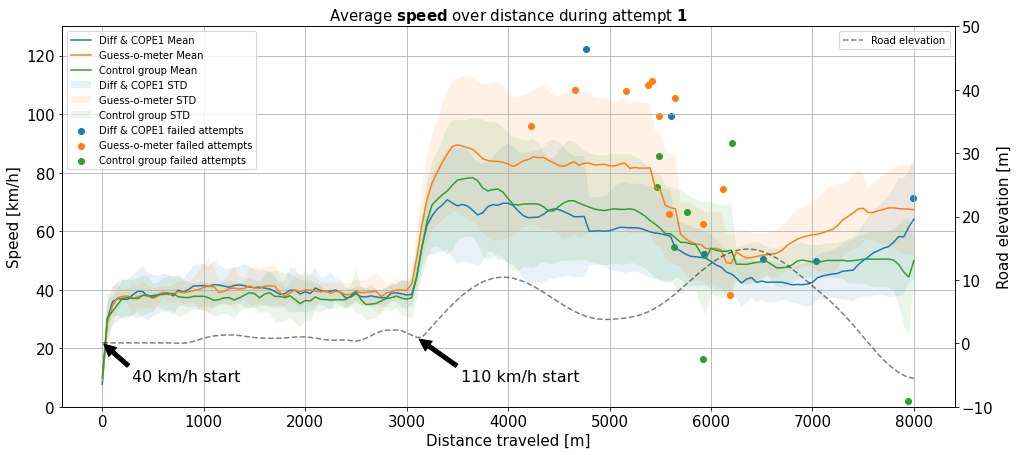

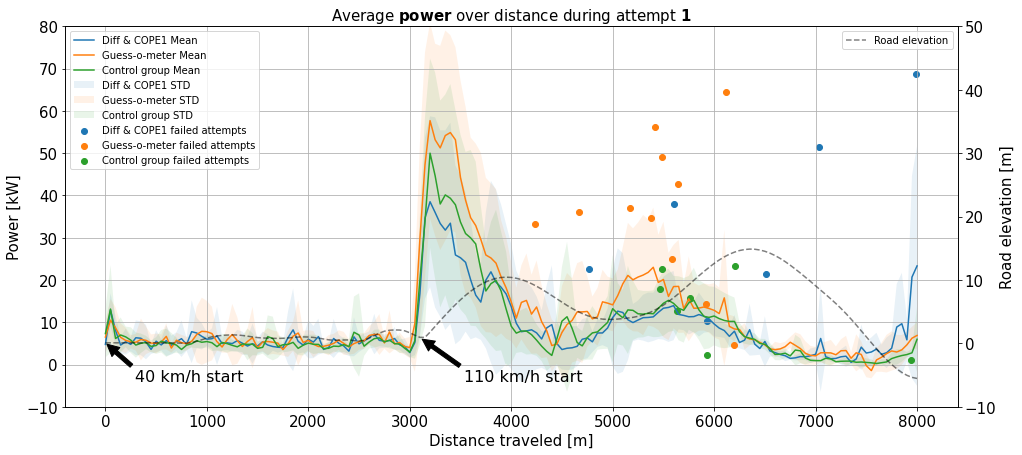

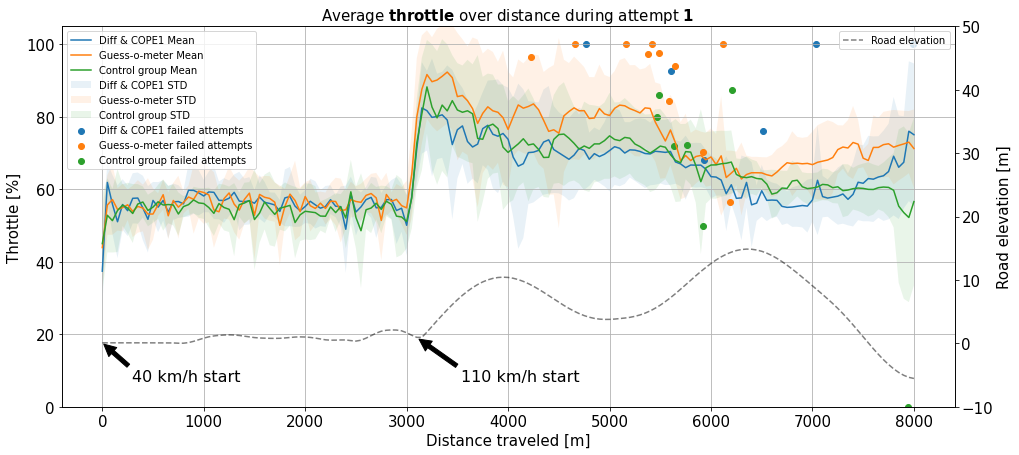

In [134]:
def plotGroupAverage(variable, attempt):
  variable_to_plot = variable
  attempt_nr = attempt

  fig, ax = plt.subplots(figsize=(16,7))

  groups_average = average_groups[average_groups.attempt == attempt_nr]
  
  # plot mean
  diff_cope_mean = average_groups[(average_groups.evis_id == "diff_and_cope1") & (average_groups.attempt == attempt_nr)]
  plt.plot(diff_cope_mean.distance_window, diff_cope_mean[variable_to_plot], label="Diff & COPE1 Mean")
  
  guess_o_meter_mean = average_groups[(average_groups.evis_id == "guess_o_meter") & (average_groups.attempt == attempt_nr)]
  plt.plot(guess_o_meter_mean.distance_window, guess_o_meter_mean[variable_to_plot], label="Guess-o-meter Mean")

  control_group_mean = average_groups[(average_groups.evis_id == "control_group") & (average_groups.attempt == attempt_nr)]
  plt.plot(control_group_mean.distance_window, control_group_mean[variable_to_plot], label="Control group Mean")
  
  # plot STD
  plt.gca().set_prop_cycle(None) # Restarts the color cycle
  std_alpha = 0.1
  
  diff_group_std = std_groups[(std_groups.attempt == attempt_nr) & (std_groups.evis_id == "diff_and_cope1")]
  plt.fill_between(
    diff_group_std.distance_window, 
    diff_cope_mean[variable_to_plot] + diff_group_std[variable_to_plot],
    diff_cope_mean[variable_to_plot] - diff_group_std[variable_to_plot],
    alpha=std_alpha, label="Diff & COPE1 STD")

  guess_o_meter_std = std_groups[(std_groups.attempt == attempt_nr) & (std_groups.evis_id == "guess_o_meter")]
  plt.fill_between(
    guess_o_meter_mean.distance_window, 
    guess_o_meter_mean[variable_to_plot] + guess_o_meter_std[variable_to_plot],
    guess_o_meter_mean[variable_to_plot] - guess_o_meter_std[variable_to_plot],
    alpha=std_alpha, label="Guess-o-meter STD")
  
  control_group_std = std_groups[(std_groups.attempt == attempt_nr) & (std_groups.evis_id == "control_group")]
  plt.fill_between(
    control_group_mean.distance_window, 
    control_group_mean[variable_to_plot] + control_group_std[variable_to_plot],
    control_group_mean[variable_to_plot] - control_group_std[variable_to_plot],
    alpha=std_alpha, label="Control group STD")
  
  # plot fails
  plt.gca().set_prop_cycle(None)
  
  if not exclude_failed_attempts:
    failed_diff_and_cope = failed_attempts[(failed_attempts.evis_id == "diff_and_cope1") & (failed_attempts.attempt == attempt_nr)]
    plt.scatter(failed_diff_and_cope.distance_traveled, failed_diff_and_cope[variable_to_plot], label="Diff & COPE1 failed attempts")

    failed_guess = failed_attempts[(failed_attempts.evis_id == "guess_o_meter") & (failed_attempts.attempt == attempt_nr)]
    plt.scatter(failed_guess.distance_traveled, failed_guess[variable_to_plot], label="Guess-o-meter failed attempts")

    failed_control_group = failed_attempts[(failed_attempts.evis_id == "control_group") & (failed_attempts.attempt == attempt_nr)]
    plt.scatter(failed_control_group.distance_traveled, failed_control_group[variable_to_plot], label="Control group failed attempts")

  # plot road elevation
  road_evel_ax = ax.twinx()
  road_plot = road_evel_ax.plot(road_elevation.distance_window, road_elevation.road_elevation, "--", color="k", label="Road elevation", alpha=0.5)
  road_evel_ax.set_ylim(-10, 50)
  road_evel_ax.set_ylabel("Road elevation [m]")
  
  # hlines at speed signs
  #road_evel_ax.vlines(0,-100,200, "tab:olive", linewidth=2.0, linestyles="dotted", alpha=1.0, label="40 km/h road start")
  #road_evel_ax.vlines(3100,-100,200, "tab:cyan", linewidth=2.0, linestyles="dotted", alpha=1.0, label="110 km/h road start")
  #road_evel_ax.vlines(8000,-100,200, "tab:purple", linewidth=2.0, linestyles="dotted", alpha=1.0, label="Charging station")
  
  # Arrows pointing to speed signs
  road_evel_ax.annotate('40 km/h start', (0, road_elevation.road_elevation[0]),
            xytext=(0.2, 0.1), textcoords='axes fraction',
            arrowprops=dict(facecolor='black', shrink=0.05),
            fontsize=16,
            horizontalalignment='right', verticalalignment='top')
  road_evel_ax.annotate('110 km/h start', (3100, road_elevation.road_elevation[30]),
          xytext=(0.58, 0.1), textcoords='axes fraction',
          arrowprops=dict(facecolor='black', shrink=0.05),
          fontsize=16,
          horizontalalignment='right', verticalalignment='top')
  
  # Set figure title
  tb1 = r"$\bf{" + variables_print_pretty[variable_to_plot].lower() + "}$"
  tb2 = r"$\bf{" + str(attempt) + "}$"
  ax.set_title("Average " + tb1 + " over distance during attempt " + tb2)
  
  # Set the y-lim based on what variable we are plotting
  if variable_to_plot == "speed":
    ax.set_ylim(0,130)
  if variable_to_plot == "power_usage":
    ax.set_ylim(-10,80)
  if variable_to_plot == "throttle_position":
    ax.set_ylim(0,105)
 
  road_evel_ax.legend()
  ax.legend(loc="upper left")  
  ax.grid(True)
  ax.set_xlabel("Distance traveled [m]")
  ax.set_ylabel(variables_print_pretty[variable_to_plot] + " " + variables_unit[variable_to_plot])
  
  #ax.xaxis.set_minor_locator(MultipleLocator(100))
  ax.xaxis.grid(True, which='minor')

  if True:
    title = "average_" + variables_print_pretty[variable_to_plot].lower() + "_attempt_" + str(attempt) + "_fine_" + "excluded_ids_" + str(exclusion_list)
    #plt.savefig("/home/steve/Pictures/figures/only successful attempts/" + title + ".png", dpi=200)
    #title = "sample_distance_"+str(distance_window_size)+"m"
    plt.savefig("/home/steve/Pictures/figures/30-3/" + title + ".png", dpi=200)

  plt.show()
  
  
variable = "speed"
plotGroupAverage(variable, 1)
#plotGroupAverage(variable, 2)
variable = "power_usage"
plotGroupAverage(variable, 1)
#plotGroupAverage(variable, 2)
variable = "throttle_position"
plotGroupAverage(variable, 1)
#plotGroupAverage(variable, 2)
variable = "current_soc"
#plotGroupAverage(variable, 1)

## Plot EVIS individually

In [135]:
params = {
    'font.size': 12,
    'axes.labelsize': 15,
    'axes.titlesize': 15,
    'legend.fontsize': 12,
    'xtick.labelsize': 15,
    'ytick.labelsize': 15
}
matplotlib.rcParams.update(params)

def plotIndividualAverages(variable, attempt, save_images):
  variable_to_plot = variable
  attempt_nr = attempt

  fig, ax = plt.subplots(figsize=(15,7))

  groups_average = average_groups[average_groups.attempt == attempt_nr]

  # Speed mean
  diff_cope_mean_1 = average_groups[(average_groups.evis_id == "diff_and_cope1") & (average_groups.attempt == 1)]
  plt.plot(diff_cope_mean_1.distance_window, diff_cope_mean_1[variable_to_plot], label="Diff & COPE1 Mean Attempt 1")
  
  diff_cope_mean_2 = average_groups[(average_groups.evis_id == "diff_and_cope1") & (average_groups.attempt == 2)]
  plt.plot(diff_cope_mean_2.distance_window, diff_cope_mean_2[variable_to_plot], label="Diff & COPE1 Mean Attempt 2")
   
  # speed STD
  plt.gca().set_prop_cycle(None) # Restarts the color cycle
  std_alpha = 0.1
  for i in range(2):
    diff_cope_mean = average_groups[(average_groups.evis_id == "diff_and_cope1") & (average_groups.attempt == i+1)]
    diff_group_std = std_groups[(std_groups.attempt == i+1) & (std_groups.evis_id == "diff_and_cope1")]
    plt.fill_between(
      diff_group_std.distance_window, 
      diff_cope_mean[variable_to_plot] + diff_group_std[variable_to_plot],
      diff_cope_mean[variable_to_plot] - diff_group_std[variable_to_plot],
      alpha=std_alpha, label="Diff & COPE1 STD attempt " + str(i+1))
  
  # Fails
  plt.gca().set_prop_cycle(None)

  for i in range(2):
    failed_diff_and_cope = failed_attempts[(failed_attempts.evis_id == "diff_and_cope1") & (failed_attempts.attempt == i+1)]
    plt.scatter(failed_diff_and_cope.distance_traveled, failed_diff_and_cope[variable_to_plot], label="Diff & COPE1 fails attempt " + str(i+1))

  # Road elevation
  road_evel_ax = ax.twinx()
  road_plot = road_evel_ax.plot(road_elevation.distance_window, road_elevation.road_elevation, "--", color="k", label="Road elevation", alpha=0.5)
  road_evel_ax.set_ylim(-10, 50)
  road_evel_ax.set_ylabel("Road elevation [m]")
  
  title = "Average " + str(variable_to_plot) + " during attempt " + str(attempt_nr)
  plt.title(title)
  ax.legend(loc="upper left")
  #ax.set_ylim(0,130)
  road_evel_ax.legend()
  ax.grid(True)
  ax.set_xlabel("Distance traveled [m]")
  ax.set_ylabel(str(variable_to_plot) + " [km/h]")

  if save_images:
    plt.savefig("/home/steve/Pictures/figures/" + title + ".png", dpi=200)

  plt.show()
  
  
save_images = False
variable = "speed"
#plotIndividualAverages(variable, 1, save_images)
#plotIndividualAverages(variable, 2, save_images)

## Plot each driver individually
Here I plot each user's first and second attempt in individual plots

In [136]:
params = {
    'font.size': 12,
    'axes.labelsize': 15,
    'axes.titlesize': 15,
    'legend.fontsize': 12,
    'xtick.labelsize': 15,
    'ytick.labelsize': 15
}

matplotlib.rcParams.update(params)

def plotIndividualAverages(variable, save_images):
  variable_to_plot = variable
  
  counter = 0
  
  for id, data in average_individual.groupby(["user_id"]):
    fig, ax = plt.subplots(figsize=(15,7))
    
    evis = data["evis_id"].iloc[0] # Get which evis the driver is using
    attempt = data["attempt"].iloc[0] # Get which attempt
    
    a1 = data[data["attempt"] == 1]
    a2 = data[data["attempt"] == 2]
    
    plt.plot(a1.distance_window, a1[variable_to_plot] * 100, label="Attempt #1")
    plt.plot(a2.distance_window, a2[variable_to_plot] * 100, label="Attempt #2")
    
    # Road elevation
    ax_secondary = ax.twinx()
    ax_secondary.plot(road_elevation.distance_window, road_elevation.road_elevation, "--", color="k", label="Road elevation", alpha=0.3)
    ax_secondary.set_ylim(-10, 50)
    ax_secondary.set_ylabel("Road elevation [m]")
    
    ax_secondary.vlines(0,-100,200, "tab:olive", linewidth=2.0, linestyles="dotted", alpha=1.0, label="40 km/h road start")
    ax_secondary.vlines(3100,-100,200, "tab:cyan", linewidth=2.0, linestyles="dotted", alpha=1.0, label="110 km/h road start")
    ax_secondary.vlines(8000,-100,200, "tab:purple", linewidth=2.0, linestyles="dotted", alpha=1.0, label="Charging station")
        
    #tb1 = r"$\bf{" + str(variable_to_plot.capitalize()) + "}$"
    tb1 = r"$\bf{" + "Throttle" + "}$"
    tb2 = r"$\bf{" + "distance" + "}$"
    tb3 = r"$\bf{" + str(id) + "}$"
    tb4 = r"$\bf{" + variables_print_pretty[evis] + "}$"
    if(evis == "control_group"):
      evis_temp = variables_print_pretty[evis].split(" ")
      tb4 = r"$\bf{" + evis_temp[0] + "}$" + " " + r"$\bf{" + evis_temp[1] + "}$"
    
    ax.set_title(tb1 + " over " + tb2 + " for user with id " + tb3 + " using EVIS " + tb4)
    
    ax.grid(True)
    ax.set_xlabel("Distance traveled [km/h]")
    ax.set_ylabel("Throttle [%]")
    ax.set_ylim(0,105)
    #ax.set_ylim(0,1)
    ax.legend(loc="upper left", framealpha=1).set_zorder(200)
    ax_secondary.legend(loc="lower left", framealpha=1).set_zorder(100)
    plt.tight_layout()
    
    ax.set_zorder(1)
    ax_secondary.set_zorder(2)
    
    if True:
      file_name = str(id) + "_" + str(evis) + "_" + str(variable_to_plot)
      plt.savefig("/home/steve/Pictures/figures/individual_attempts/throttle/" + file_name + ".png", dpi=200)

    
    counter += 1

    #if counter > 2:
    #  return
  
  
save_images = False
variable = "throttle_position"
#plotIndividualAverages(variable, save_images)


## Check averages over specific sections

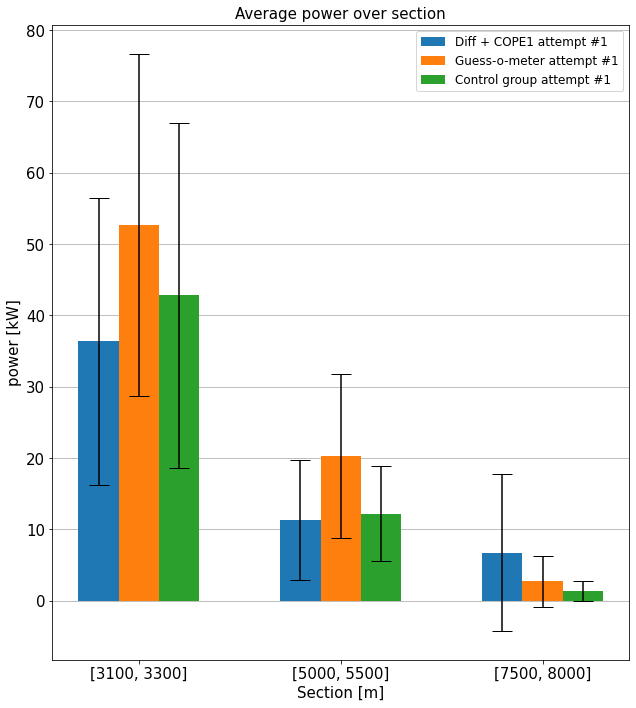

In [137]:
def getSectionSpecificData(window, evis, attempt):   
  # Select all individual drives within the given distance window span, evis, and attempt nr
  return average_individual[
    (average_individual.distance_window > window[0]) & (average_individual.distance_window < window[1]) &
    (average_individual.evis_id == evis) &
    (average_individual.attempt == attempt)
  ].copy()

# Choose which section
#sections = [[0, 3100], [3100, 6350], [6350, 8000]]
sections = [[3100, 3300], [5000,5500], [7500,8000]]

mean_std_data_frames = []
for j,section in enumerate(sections):
  # Get the values for both diff & guess at attempt 1 & 2
  for evis in ["diff_and_cope1", "guess_o_meter", "control_group"]:
    for i in range(2):
      # Get the data from each user for the specific section
      section_data = getSectionSpecificData(section, evis, i+1)
      
      # Calculate the average over the specific section for all whom used a specific EVIS
      average_section = section_data.groupby(["attempt", "evis_id"], as_index=False).mean()
      average_section["section"] = str(section)
      average_section["data_type"] = "mean"
      
      # Calculate the std over the specific section
      std_section = section_data.groupby(["attempt", "evis_id"], as_index=False).std()
      std_section["section"] = str(section)
      std_section["data_type"] = "std"
      
      mean_std_data_frames.append(average_section)
      mean_std_data_frames.append(std_section)
        
final_data = pd.concat(mean_std_data_frames)

## PLOT ###

fig_bar, ax_bar = plt.subplots(figsize=(9, 10))

x_pos = np.arange(len(sections))
width = 0.2
capsize=10
variable_to_plot = "power_usage"

### Attempt #1 ###

evis = "diff_and_cope1"
a1_diff_mean = final_data[(final_data.evis_id == evis) & (final_data.attempt == 1) & (final_data.data_type == "mean")]
a1_diff_std = final_data[(final_data.evis_id == evis) & (final_data.attempt == 1) & (final_data.data_type == "std")]

#ax_bar.bar(x_pos - (width*2 + width/2) - (width*0.2), 
ax_bar.bar(x_pos - width, 
      a1_diff_mean[variable_to_plot], 
      yerr=a1_diff_std[variable_to_plot], 
      width=width, 
      label="Diff + COPE1 attempt #1", 
      hatch="", capsize=capsize,
      zorder=3)

evis = "guess_o_meter"
a1_guess_mean = final_data[(final_data.evis_id == evis) & (final_data.attempt == 1) & (final_data.data_type == "mean")]
a1_guess_std = final_data[(final_data.evis_id == evis) & (final_data.attempt == 1) & (final_data.data_type == "std")]

#ax_bar.bar(x_pos - (width + width/2) - (width*0.2), 
ax_bar.bar(x_pos, 
      a1_guess_mean[variable_to_plot], 
      yerr=a1_guess_std[variable_to_plot], 
      width=width, 
      label="Guess-o-meter attempt #1", 
      hatch="", capsize=capsize,
      zorder=3)

evis = "control_group"
a1_control_mean = final_data[(final_data.evis_id == evis) & (final_data.attempt == 1) & (final_data.data_type == "mean")]
a1_control_std = final_data[(final_data.evis_id == evis) & (final_data.attempt == 1) & (final_data.data_type == "std")]

#ax_bar.bar(x_pos - (width*0 + width/2)- (width*0.2), 
ax_bar.bar(x_pos + width, 
      a1_control_mean[variable_to_plot], 
      yerr=a1_control_std[variable_to_plot], 
      width=width, 
      label="Control group attempt #1", 
      hatch="", capsize=capsize,
      zorder=3)


### Attempt #2 ###
if False:
  plt.gca().set_prop_cycle(None)

  evis = "diff_and_cope1"
  attempt = 2
  a1_diff_mean = final_data[(final_data.evis_id == evis) & (final_data.attempt == attempt) & (final_data.data_type == "mean")]
  a1_diff_std = final_data[(final_data.evis_id == evis) & (final_data.attempt == attempt) & (final_data.data_type == "std")]

  ax_bar.bar(x_pos + (width*0 + width/2) + (width*0.2), 
        a1_diff_mean[variable_to_plot], 
        yerr=a1_diff_std[variable_to_plot], 
        width=width, 
        label="Diff + COPE1 attempt #2", 
        capsize=capsize,
        zorder=3)

  evis = "guess_o_meter"
  a1_guess_mean = final_data[(final_data.evis_id == evis) & (final_data.attempt == attempt) & (final_data.data_type == "mean")]
  a1_guess_std = final_data[(final_data.evis_id == evis) & (final_data.attempt == attempt) & (final_data.data_type == "std")]

  ax_bar.bar(x_pos + (width + width/2)+ (width*0.2), 
        a1_guess_mean[variable_to_plot], 
        yerr=a1_guess_std[variable_to_plot], 
        width=width, 
        label="Guess-o-meter attempt #2", 
        capsize=capsize,
        zorder=3)

  evis = "control_group"
  a1_control_mean = final_data[(final_data.evis_id == evis) & (final_data.attempt == attempt) & (final_data.data_type == "mean")]
  a1_control_std = final_data[(final_data.evis_id == evis) & (final_data.attempt == attempt) & (final_data.data_type == "std")]

  ax_bar.bar(x_pos + (width*2 + width/2)+ (width*0.2), 
        a1_control_mean[variable_to_plot], 
        yerr=a1_control_std[variable_to_plot], 
        width=width, 
        label="Control group #2", 
        capsize=capsize,
        zorder=3)

ax_bar.grid(True, axis="y",zorder=0)
ax_bar.set_xlabel("Section [m]")
ax_bar.set_ylabel(str(variables_print_pretty[variable_to_plot]).lower()+" "+str(variables_unit[variable_to_plot]))
plt.xticks(np.arange(len(sections)), [str(x) for x in sections])
plt.title("Average " + str(variables_print_pretty[variable_to_plot]).lower() + " over section")
#plt.ylim(0,100)

plt.legend(loc="upper right")
plt.tight_layout()

#title = "average_"+str(variables_print_pretty[variable_to_plot]).lower()+"_over_[3100,4000]_a1_only"
title = "TEST_2"
plt.savefig("/home/steve/Pictures/" + title + ".png", dpi=200)

plt.show()

## Auto check road sections 

In [160]:
def ttest_independent(samp_1, samp_2):
    # Check if equal variances
    s,p = stats.levene(samp_1, samp_2)
    equal_var = True
    if p < 0.05:
      equal_var = False
    
    s,p = stats.ttest_ind(samp_1, samp_2, equal_var=equal_var)
    
    return {
      "p": round(p, 4),
      "N1": samp_1.count(),
      "N2": samp_2.count(),
    }
    
# Choose which variable to plot here!
#variable = "throttle_position" 
#variable = "speed" 
#variable = "throttle_position"
variable = "power_usage"

section_size = np.array([0,300])
step_size = 50
which_attempt = 1

significant_differences = []

section = section_size.copy()  
while section[1] <= 8000:
    
    # Get the data from attempt 1 for each participant who used diff + cope1 EVIS
    evis = "diff_and_cope1"
    individual = average_individual[(average_individual.attempt == which_attempt) & (average_individual.evis_id == evis)]
    #display(individual)
    a1_mean_speeds_diff = individual.pivot(index="distance_window", columns="user_id", values=variable)
    
    # Get the data from attempt 1 for each participant who used guess-o-meter EVIS
    evis = "guess_o_meter"
    individual = average_individual[(average_individual.attempt == which_attempt) & (average_individual.evis_id == evis)] # Get one particular attempt and evis values
    a1_mean_speeds_guess = individual.pivot(index="distance_window", columns="user_id", values=variable) # Get the average speeds for each distance window for each user

    evis = "control_group"
    individual = average_individual[(average_individual.attempt == which_attempt) & (average_individual.evis_id == evis)] # Get one particular attempt and evis values
    a1_mean_speeds_control = individual.pivot(index="distance_window", columns="user_id", values=variable) # Get the average speeds for each distance window for each user
  
    # Remove users who do not have data for the entire range and then calculate mean
    a1_mean_speeds_diff_section = a1_mean_speeds_diff.loc[section[0]:section[1]].dropna(axis=1).mean()
    a1_mean_speeds_guess_section = a1_mean_speeds_guess.loc[section[0]:section[1]].dropna(axis=1).mean()
    a1_mean_speeds_control_section = a1_mean_speeds_control.loc[section[0]:section[1]].dropna(axis=1).mean()
    
    t_test_control_guess = ttest_independent(a1_mean_speeds_control_section, a1_mean_speeds_guess_section)
    t_test_control_diff = ttest_independent(a1_mean_speeds_control_section, a1_mean_speeds_diff_section)
    t_test_diff_guess = ttest_independent(a1_mean_speeds_diff_section, a1_mean_speeds_guess_section)
    
    any_one_found = False
    if (t_test_control_diff["p"] < 0.05 or t_test_control_guess["p"] < 0.05 or  t_test_diff_guess["p"] < 0.05):
      any_one_found = True
    
    if any_one_found:
      """print("\nt-test between control & diff " + str(section))
      print("p-value", t_test_control_diff["p"])
      print("N1:", t_test_control_diff["N1"], " N2:", t_test_control_diff["N2"])"""
      if t_test_control_diff["p"] < 0.05:
        #display(Markdown("<font color='green'>There is a statistical difference between the means</font>"))
        significant_differences.append({"section":section.copy(), "which":"control & diff"})
      
    if any_one_found:
      """print("\nt-test between control & guess " + str(section))
      print("N1:", t_test_control_guess["N1"], " N2:", t_test_control_guess["N2"])
      print("p-value", t_test_control_guess["p"])"""
      if t_test_control_guess["p"] < 0.05:
        #display(Markdown("<font color='green'>There is a statistical difference between the means</font>"))
        significant_differences.append({"section":section.copy(), "which":"control & guess"})
    
    if any_one_found:
      """print("\nt-test between diff & guess" + str(section))
      print("p-value", t_test_diff_guess["p"])
      print("N1:", t_test_diff_guess["N1"], " N2:", t_test_diff_guess["N2"])"""
      if t_test_diff_guess["p"] < 0.05:
        #display(Markdown("<font color='green'>There is a statistical difference between the means</font>"))
        significant_differences.append({"section":section.copy(), "which":"diff & guess"})
      
    """if any_one_found:
      print("-"*20)"""
    
    section += step_size
print("Done")

Done


# Add statistical difference into the graph

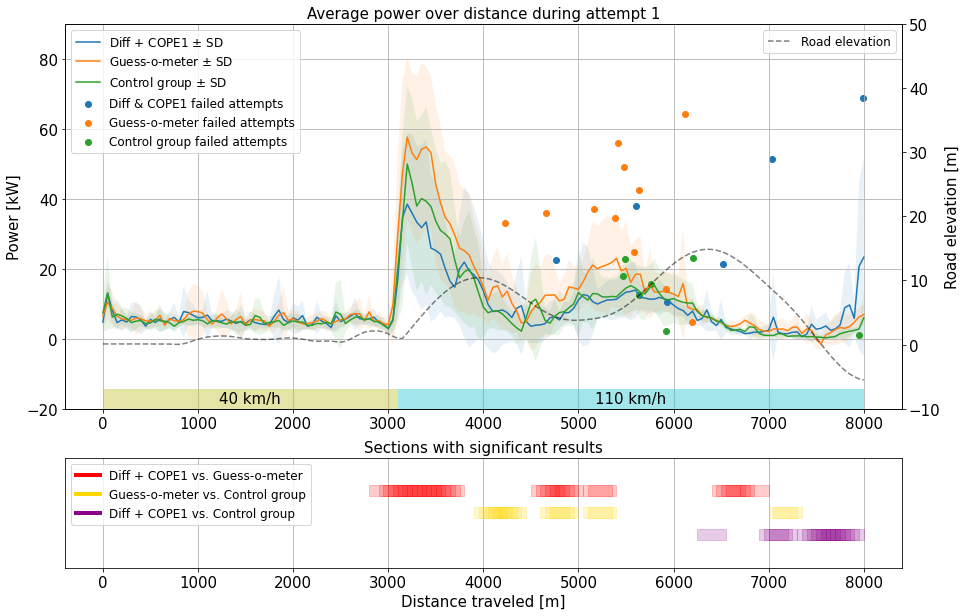

In [157]:
def plotGroupAverage(variable, attempt):
  variable_to_plot = variable
  attempt_nr = attempt

  #fig, ax = plt.subplots()
  fig, (ax, ax2) = plt.subplots(2,1,figsize=(15,10),gridspec_kw={'height_ratios': [3.5, 1]})

  plus_minus = r'$\pm$'
  
  # Speed mean
  diff_cope_mean = average_groups[(average_groups.evis_id == "diff_and_cope1") & (average_groups.attempt == attempt_nr)]
  label = "Diff + COPE1 " + plus_minus + " SD"
  ax.plot(diff_cope_mean.distance_window, diff_cope_mean[variable_to_plot], label=label)
  
  guess_o_meter_mean = average_groups[(average_groups.evis_id == "guess_o_meter") & (average_groups.attempt == attempt_nr)]
  label = "Guess-o-meter " + plus_minus + " SD"
  ax.plot(guess_o_meter_mean.distance_window, guess_o_meter_mean[variable_to_plot], label=label)

  control_group_mean = average_groups[(average_groups.evis_id == "control_group") & (average_groups.attempt == attempt_nr)]
  label = "Control group " + plus_minus + " SD"
  ax.plot(control_group_mean.distance_window, control_group_mean[variable_to_plot], label=label)
  
  # speed STD
  plt.gca().set_prop_cycle(None) # Restarts the color cycle
  std_alpha = 0.1
  
  diff_group_std = std_groups[(std_groups.attempt == attempt_nr) & (std_groups.evis_id == "diff_and_cope1")]
  ax.fill_between(
    diff_group_std.distance_window, 
    diff_cope_mean[variable_to_plot] + diff_group_std[variable_to_plot],
    diff_cope_mean[variable_to_plot] - diff_group_std[variable_to_plot],
    alpha=std_alpha)

  guess_o_meter_std = std_groups[(std_groups.attempt == attempt_nr) & (std_groups.evis_id == "guess_o_meter")]
  ax.fill_between(
    guess_o_meter_mean.distance_window, 
    guess_o_meter_mean[variable_to_plot] + guess_o_meter_std[variable_to_plot],
    guess_o_meter_mean[variable_to_plot] - guess_o_meter_std[variable_to_plot],
    alpha=std_alpha)
  
  control_group_std = std_groups[(std_groups.attempt == attempt_nr) & (std_groups.evis_id == "control_group")]
  ax.fill_between(
    control_group_mean.distance_window, 
    control_group_mean[variable_to_plot] + control_group_std[variable_to_plot],
    control_group_mean[variable_to_plot] - control_group_std[variable_to_plot],
    alpha=std_alpha)
  
  # Fails
  ax.set_prop_cycle(None) # Restart color wheel
  
  failed_diff_and_cope = failed_attempts[(failed_attempts.evis_id == "diff_and_cope1") & (failed_attempts.attempt == attempt_nr)]
  ax.scatter(failed_diff_and_cope.distance_traveled, failed_diff_and_cope[variable_to_plot], label="Diff & COPE1 failed attempts")

  failed_guess = failed_attempts[(failed_attempts.evis_id == "guess_o_meter") & (failed_attempts.attempt == attempt_nr)]
  ax.scatter(failed_guess.distance_traveled, failed_guess[variable_to_plot], label="Guess-o-meter failed attempts")

  failed_control_group = failed_attempts[(failed_attempts.evis_id == "control_group") & (failed_attempts.attempt == attempt_nr)]
  ax.scatter(failed_control_group.distance_traveled, failed_control_group[variable_to_plot], label="Control group failed attempts")

  # Road elevation
  road_evel_ax = ax.twinx()
  road_plot = road_evel_ax.plot(road_elevation.distance_window, road_elevation.road_elevation, "--", color="k", label="Road elevation", alpha=0.5)
  road_evel_ax.set_ylim(-10, 50)
  road_evel_ax.set_ylabel("Road elevation [m]")
  road_evel_ax.legend()
  
  ax.set_title("Average " + variables_print_pretty[variable_to_plot].lower() + " over distance during attempt " + str(attempt))
  
  # Adjust y-range depending on variable
  if variable_to_plot == "speed":
    ax.set_ylim(0,130)
  if variable_to_plot == "power_usage":
    ax.set_ylim(-20,90)
  if variable_to_plot == "throttle_position":
    ax.set_ylim(0,105)
    
  ax.grid(True)
  ax2.set_xlabel("Distance traveled [m]")
  ax.set_ylabel(variables_print_pretty[variable_to_plot] + " " + variables_unit[variable_to_plot])
  
  ### Show significant differences ###
  thicknes = 0.1
  spacing = 0.1
  start_y_base = 0.25
  ax2.set_xlim(-400,8400)
  ax2.get_yaxis().set_visible(False)
  ax2.grid(True)
  ax2.set_title("Sections with significant results")
  
  for difference in significant_differences:
    if difference["which"] == "control & diff":
      color = "darkmagenta"
      start_y = start_y_base
    if difference["which"] == "control & guess":
      color = "gold"
      start_y = start_y_base + thicknes + spacing
    if difference["which"] == "diff & guess":
      color = "red"
      start_y = start_y_base + (thicknes + spacing) * 2
    
    start_x = difference["section"][0]
    end_x = difference["section"][1]
    
    end_y = start_y + thicknes
    
    rect = Rectangle((start_x, start_y), 
                 end_x-start_x, end_y-start_y, 
                 fill=True, 
                 zorder=100,
                 alpha=0.2,
                 color=color)
    
    ax2.add_patch(rect)  
  
  ### Mark 40 km/h area ###
  figure_height = ax.get_ylim()[1] - ax.get_ylim()[0]
  start_x = 0
  end_x = 3100
  start_y = ax.get_ylim()[0]
  end_y = start_y + (figure_height * 0.05) # 5% of fig height
  rect = Rectangle((start_x, start_y), 
                   end_x-start_x, end_y-start_y, 
                   fill=True, 
                   linewidth=0,
                   zorder=100,
                   linestyle="-", 
                   alpha=0.4,
                   color="tab:olive")
  ax.add_patch(rect)  
  ax.text((end_x-start_x)/2, end_y+(start_y-end_y)/2, '40 km/h',
        horizontalalignment='center',
        verticalalignment='center',
        fontsize=15,
        fontweight='normal',
        zorder=101)
  
  ### Mark 110 km/h area ###
  start_x = 3100
  end_x = 8000
  rect = Rectangle((start_x, start_y), 
                   end_x-start_x, end_y-start_y, 
                   fill=True, 
                   linewidth=0,
                   zorder=100,
                   linestyle="-", 
                   alpha=0.4,
                   color="tab:cyan")
  ax.add_patch(rect)  
  ax.text(start_x+(end_x-start_x)/2, end_y+(start_y-end_y)/2, '110 km/h',
        horizontalalignment='center',
        verticalalignment='center',
        fontsize=15,
        fontweight='normal',
        zorder=101)
  
  custom_lines = [Line2D([0], [0], color="red", lw=4),
                Line2D([0], [0], color="gold", lw=4),
                Line2D([0], [0], color="darkmagenta", lw=4)]
  ax2.legend(custom_lines, 
             ['Diff + COPE1 vs. Guess-o-meter', 'Guess-o-meter vs. Control group', 'Diff + COPE1 vs. Control group'])
  ax.legend(loc="upper left")
  
  title = "searching_for_significance_section_size"+str(section_size)+"_step_size_"+str(step_size)
  
  plt.savefig("/home/steve/Pictures/figures/16-4/" + title + ".png", dpi=200)
  
  plt.show()

  
  
#!!!! Make sure to only plot the variable which we are checking for significant differences on in the cell above!!!!  
plotGroupAverage(variable, 1)
#plotGroupAverage(variable, 2)

# Check specific sections

In [140]:
def ttest_independent(samp_1, samp_2):
    # Check if equal variances
    s,p = stats.levene(samp_1, samp_2)
    equal_var = True
    if p < 0.05:
      equal_var = False
    
    s,p = stats.ttest_ind(samp_1, samp_2, equal_var=equal_var)
    
    return {
      "p": round(p, 4),
      "N1": samp_1.count(),
      "N2": samp_2.count(),
      "samp1": samp_1,
      "samp2": samp_2,
      "samp1_mean": round(samp_1.mean(), 2),
      "samp2_mean": round(samp_2.mean(), 2)
    }
    
variable = "power_usage" 
significant_differences = []


sections = [
  [3000, 3650],
  [3950, 4450],
  
  [4600, 5050],
  [4650, 4950],

  [5150, 5400],

  [6050, 7000],
  
  [7000, 7350],
  
  [5900, 7950],
  
  [7500, 7950],
  [7500, 8000]
]

for section in sections:
    print("Checking: " + str(section))
    evis = "diff_and_cope1"
    individual = average_individual[(average_individual.attempt == which_attempt) & (average_individual.evis_id == evis)] # Get one particular attempt and evis values
    a1_mean_speeds_diff = individual.pivot(index="distance_window", columns="user_id", values=variable) # Get the average speeds for each distance window for each user
    
    #display(individual.groupby(["user_id"]).tail(1))
    
    evis = "guess_o_meter"
    individual = average_individual[(average_individual.attempt == which_attempt) & (average_individual.evis_id == evis)] # Get one particular attempt and evis values
    a1_mean_speeds_guess = individual.pivot(index="distance_window", columns="user_id", values=variable) # Get the average speeds for each distance window for each user

    evis = "control_group"
    individual = average_individual[(average_individual.attempt == which_attempt) & (average_individual.evis_id == evis)] # Get one particular attempt and evis values
    a1_mean_speeds_control = individual.pivot(index="distance_window", columns="user_id", values=variable) # Get the average speeds for each distance window for each user
  
    # Remove users who do not have data for the entire range and then calculate mean
    a1_mean_speeds_diff_section = a1_mean_speeds_diff.loc[section[0]:section[1]].dropna(axis=1).mean()
    a1_mean_speeds_guess_section = a1_mean_speeds_guess.loc[section[0]:section[1]].dropna(axis=1).mean()
    a1_mean_speeds_control_section = a1_mean_speeds_control.loc[section[0]:section[1]].dropna(axis=1).mean()
    
    t_test_control_guess = ttest_independent(a1_mean_speeds_control_section, a1_mean_speeds_guess_section)
    t_test_control_diff = ttest_independent(a1_mean_speeds_control_section, a1_mean_speeds_diff_section)
    t_test_diff_guess = ttest_independent(a1_mean_speeds_diff_section, a1_mean_speeds_guess_section)
    
    any_one_found = False
    if (t_test_control_diff["p"] < 0.05 or t_test_control_guess["p"] < 0.05 or  t_test_diff_guess["p"] < 0.05):
      any_one_found = True
    
    if any_one_found:
      print("\nt-test between control & diff " + str(section))
      print("p-value", t_test_control_diff["p"])
      print("N1:", t_test_control_diff["N1"], " N2:", t_test_control_diff["N2"])
      print("control mean:", t_test_control_diff["samp1_mean"], "diff mean:", t_test_control_diff["samp2_mean"])
      if t_test_control_diff["p"] < 0.05:
        display(Markdown("<font color='green'>There is a statistical difference between the means</font>"))
        significant_differences.append({
          "section":section.copy(), 
          "which":"control & diff", 
          "p-value": t_test_control_diff["p"], 
          "N Control": t_test_control_diff["N1"], 
          "N diff + COPE1": t_test_control_diff["N2"],
          "control mean": t_test_control_diff["samp1_mean"],
          "diff mean": t_test_control_diff["samp2_mean"]
        })
      
    if any_one_found:
      print("\nt-test between control & guess " + str(section))
      print("N1:", t_test_control_guess["N1"], " N2:", t_test_control_guess["N2"])
      print("p-value", t_test_control_guess["p"])
      if t_test_control_guess["p"] < 0.05:
        display(Markdown("<font color='green'>There is a statistical difference between the means</font>"))
        significant_differences.append({
          "section":section.copy(), 
          "which":"control & guess", 
          "p-value": t_test_control_guess["p"],
          "N control": t_test_control_guess["N1"],
          "N guess": t_test_control_guess["N2"],
          "control mean": t_test_control_diff["samp1_mean"],
          "guess mean": t_test_control_diff["samp2_mean"]
        })
    
    if any_one_found:
      print("\nt-test between diff & guess" + str(section))
      print("p-value", t_test_diff_guess["p"])
      print("N1:", t_test_diff_guess["N1"], " N2:", t_test_diff_guess["N2"])
      if t_test_diff_guess["p"] < 0.05:
        display(Markdown("<font color='green'>There is a statistical difference between the means</font>"))
        significant_differences.append({
          "section":section.copy(), 
          "which":"diff & guess", 
          "p-value": t_test_diff_guess["p"],
          "N diff + COPE1": t_test_diff_guess["N1"],
          "N guess": t_test_diff_guess["N2"],
          "diff mean": t_test_control_diff["samp1_mean"],
          "guess mean": t_test_control_diff["samp2_mean"]
        })
      
    if any_one_found:
      print("-"*20)

Checking: [3000, 3650]

t-test between control & diff [3000, 3650]
p-value 0.222
N1: 13  N2: 13
control mean: 31.1 diff mean: 24.59

t-test between control & guess [3000, 3650]
N1: 13  N2: 14
p-value 0.1322

t-test between diff & guess[3000, 3650]
p-value 0.0126
N1: 13  N2: 14


<font color='green'>There is a statistical difference between the means</font>

--------------------
Checking: [3950, 4450]

t-test between control & diff [3950, 4450]
p-value 0.3724
N1: 13  N2: 13
control mean: 6.73 diff mean: 9.15

t-test between control & guess [3950, 4450]
N1: 13  N2: 13
p-value 0.0109


<font color='green'>There is a statistical difference between the means</font>


t-test between diff & guess[3950, 4450]
p-value 0.4203
N1: 13  N2: 13
--------------------
Checking: [4600, 5050]

t-test between control & diff [4600, 5050]
p-value 0.3533
N1: 13  N2: 12
control mean: 8.37 diff mean: 6.85

t-test between control & guess [4600, 5050]
N1: 13  N2: 12
p-value 0.0537

t-test between diff & guess[4600, 5050]
p-value 0.0084
N1: 12  N2: 12


<font color='green'>There is a statistical difference between the means</font>

--------------------
Checking: [4650, 4950]

t-test between control & diff [4650, 4950]
p-value 0.3572
N1: 13  N2: 12
control mean: 7.14 diff mean: 5.99

t-test between control & guess [4650, 4950]
N1: 13  N2: 12
p-value 0.0162


<font color='green'>There is a statistical difference between the means</font>


t-test between diff & guess[4650, 4950]
p-value 0.0041
N1: 12  N2: 12


<font color='green'>There is a statistical difference between the means</font>

--------------------
Checking: [5150, 5400]

t-test between control & diff [5150, 5400]
p-value 0.5119
N1: 13  N2: 12
control mean: 12.29 diff mean: 10.75

t-test between control & guess [5150, 5400]
N1: 13  N2: 11
p-value 0.0414


<font color='green'>There is a statistical difference between the means</font>


t-test between diff & guess[5150, 5400]
p-value 0.0198
N1: 12  N2: 11


<font color='green'>There is a statistical difference between the means</font>

--------------------
Checking: [6050, 7000]

t-test between control & diff [6050, 7000]
p-value 0.1021
N1: 7  N2: 9
control mean: 4.64 diff mean: 4.07

t-test between control & guess [6050, 7000]
N1: 7  N2: 3
p-value 0.0808

t-test between diff & guess[6050, 7000]
p-value 0.0126
N1: 9  N2: 3


<font color='green'>There is a statistical difference between the means</font>

--------------------
Checking: [7000, 7350]

t-test between control & diff [7000, 7350]
p-value 0.0406
N1: 7  N2: 8
control mean: 0.96 diff mean: 1.66


<font color='green'>There is a statistical difference between the means</font>


t-test between control & guess [7000, 7350]
N1: 7  N2: 3
p-value 0.0454


<font color='green'>There is a statistical difference between the means</font>


t-test between diff & guess[7000, 7350]
p-value 0.1933
N1: 8  N2: 3
--------------------
Checking: [5900, 7950]

t-test between control & diff [5900, 7950]
p-value 0.0548
N1: 7  N2: 8
control mean: 3.39 diff mean: 4.62

t-test between control & guess [5900, 7950]
N1: 7  N2: 3
p-value 0.0358


<font color='green'>There is a statistical difference between the means</font>


t-test between diff & guess[5900, 7950]
p-value 0.9947
N1: 8  N2: 3
--------------------
Checking: [7500, 7950]

t-test between control & diff [7500, 7950]
p-value 0.0068
N1: 7  N2: 8
control mean: 1.26 diff mean: 6.34


<font color='green'>There is a statistical difference between the means</font>


t-test between control & guess [7500, 7950]
N1: 7  N2: 3
p-value 0.2591

t-test between diff & guess[7500, 7950]
p-value 0.1382
N1: 8  N2: 3
--------------------
Checking: [7500, 8000]

t-test between control & diff [7500, 8000]
p-value 0.0135
N1: 6  N2: 8
control mean: 1.78 diff mean: 7.88


<font color='green'>There is a statistical difference between the means</font>


t-test between control & guess [7500, 8000]
N1: 6  N2: 3
p-value 0.3353

t-test between diff & guess[7500, 8000]
p-value 0.1539
N1: 8  N2: 3
--------------------


In [141]:
for x in significant_differences:
  print(x)

{'section': [3000, 3650], 'which': 'diff & guess', 'p-value': 0.0126, 'N diff + COPE1': 13, 'N guess': 14, 'diff mean': 31.1, 'guess mean': 24.59}
{'section': [3950, 4450], 'which': 'control & guess', 'p-value': 0.0109, 'N control': 13, 'N guess': 13, 'control mean': 6.73, 'guess mean': 9.15}
{'section': [4600, 5050], 'which': 'diff & guess', 'p-value': 0.0084, 'N diff + COPE1': 12, 'N guess': 12, 'diff mean': 8.37, 'guess mean': 6.85}
{'section': [4650, 4950], 'which': 'control & guess', 'p-value': 0.0162, 'N control': 13, 'N guess': 12, 'control mean': 7.14, 'guess mean': 5.99}
{'section': [4650, 4950], 'which': 'diff & guess', 'p-value': 0.0041, 'N diff + COPE1': 12, 'N guess': 12, 'diff mean': 7.14, 'guess mean': 5.99}
{'section': [5150, 5400], 'which': 'control & guess', 'p-value': 0.0414, 'N control': 13, 'N guess': 11, 'control mean': 12.29, 'guess mean': 10.75}
{'section': [5150, 5400], 'which': 'diff & guess', 'p-value': 0.0198, 'N diff + COPE1': 12, 'N guess': 11, 'diff mean'

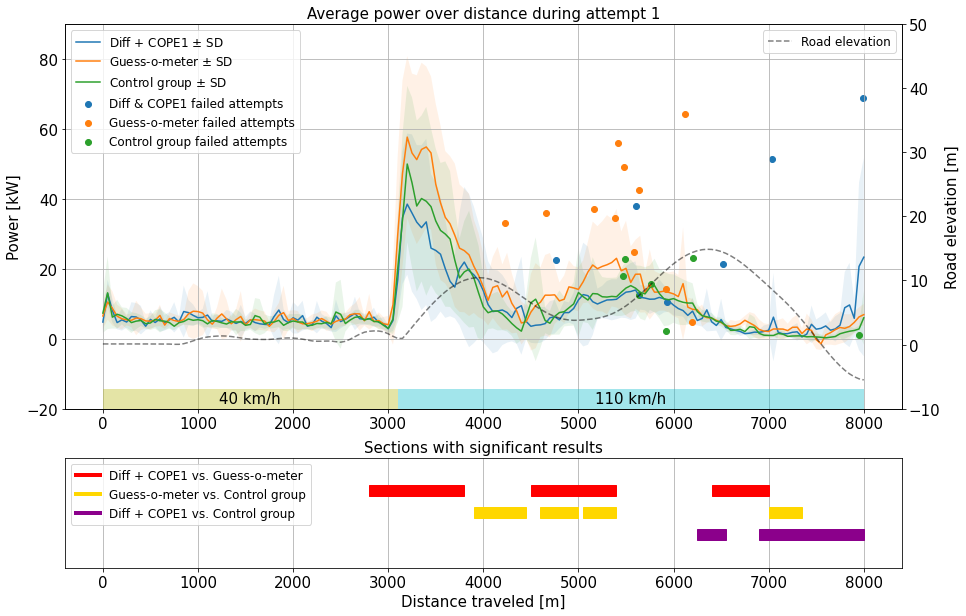

In [161]:
def plotGroupAverage(variable, attempt):
  variable_to_plot = variable
  attempt_nr = attempt

  #fig, ax = plt.subplots()
  fig, (ax, ax2) = plt.subplots(2,1,figsize=(15,10),gridspec_kw={'height_ratios': [3.5, 1]})

  plus_minus = r'$\pm$'
  
  # Speed mean
  diff_cope_mean = average_groups[(average_groups.evis_id == "diff_and_cope1") & (average_groups.attempt == attempt_nr)]
  label = "Diff + COPE1 " + plus_minus + " SD"
  ax.plot(diff_cope_mean.distance_window, diff_cope_mean[variable_to_plot], label=label)
  
  guess_o_meter_mean = average_groups[(average_groups.evis_id == "guess_o_meter") & (average_groups.attempt == attempt_nr)]
  label = "Guess-o-meter " + plus_minus + " SD"
  ax.plot(guess_o_meter_mean.distance_window, guess_o_meter_mean[variable_to_plot], label=label)

  control_group_mean = average_groups[(average_groups.evis_id == "control_group") & (average_groups.attempt == attempt_nr)]
  label = "Control group " + plus_minus + " SD"
  ax.plot(control_group_mean.distance_window, control_group_mean[variable_to_plot], label=label)
  
  # speed STD
  plt.gca().set_prop_cycle(None) # Restarts the color cycle
  std_alpha = 0.1
  
  diff_group_std = std_groups[(std_groups.attempt == attempt_nr) & (std_groups.evis_id == "diff_and_cope1")]
  ax.fill_between(
    diff_group_std.distance_window, 
    diff_cope_mean[variable_to_plot] + diff_group_std[variable_to_plot],
    diff_cope_mean[variable_to_plot] - diff_group_std[variable_to_plot],
    alpha=std_alpha)

  guess_o_meter_std = std_groups[(std_groups.attempt == attempt_nr) & (std_groups.evis_id == "guess_o_meter")]
  ax.fill_between(
    guess_o_meter_mean.distance_window, 
    guess_o_meter_mean[variable_to_plot] + guess_o_meter_std[variable_to_plot],
    guess_o_meter_mean[variable_to_plot] - guess_o_meter_std[variable_to_plot],
    alpha=std_alpha)
  
  control_group_std = std_groups[(std_groups.attempt == attempt_nr) & (std_groups.evis_id == "control_group")]
  ax.fill_between(
    control_group_mean.distance_window, 
    control_group_mean[variable_to_plot] + control_group_std[variable_to_plot],
    control_group_mean[variable_to_plot] - control_group_std[variable_to_plot],
    alpha=std_alpha)
  
  # Fails
  ax.set_prop_cycle(None) # Restart color wheel
  
  failed_diff_and_cope = failed_attempts[(failed_attempts.evis_id == "diff_and_cope1") & (failed_attempts.attempt == attempt_nr)]
  ax.scatter(failed_diff_and_cope.distance_traveled, failed_diff_and_cope[variable_to_plot], label="Diff & COPE1 failed attempts")

  failed_guess = failed_attempts[(failed_attempts.evis_id == "guess_o_meter") & (failed_attempts.attempt == attempt_nr)]
  ax.scatter(failed_guess.distance_traveled, failed_guess[variable_to_plot], label="Guess-o-meter failed attempts")

  failed_control_group = failed_attempts[(failed_attempts.evis_id == "control_group") & (failed_attempts.attempt == attempt_nr)]
  ax.scatter(failed_control_group.distance_traveled, failed_control_group[variable_to_plot], label="Control group failed attempts")

  # Road elevation
  road_evel_ax = ax.twinx()
  road_plot = road_evel_ax.plot(road_elevation.distance_window, road_elevation.road_elevation, "--", color="k", label="Road elevation", alpha=0.5)
  road_evel_ax.set_ylim(-10, 50)
  road_evel_ax.set_ylabel("Road elevation [m]")
  road_evel_ax.legend()
  
  ax.set_title("Average " + variables_print_pretty[variable_to_plot].lower() + " over distance during attempt " + str(attempt))
  
  # Adjust y-range depending on variable
  if variable_to_plot == "speed":
    ax.set_ylim(0,130)
  if variable_to_plot == "power_usage":
    ax.set_ylim(-20,90)
  if variable_to_plot == "throttle_position":
    ax.set_ylim(0,105)
    
  ax.grid(True)
  ax2.set_xlabel("Distance traveled [m]")
  ax.set_ylabel(variables_print_pretty[variable_to_plot] + " " + variables_unit[variable_to_plot])
  
  ### Show significant differences ###
  thicknes = 0.1
  spacing = 0.1
  start_y_base = 0.25
  ax2.set_xlim(-400,8400)
  ax2.get_yaxis().set_visible(False)
  ax2.grid(True)
  ax2.set_title("Sections with significant results")
  
  for difference in significant_differences:
    if difference["which"] == "control & diff":
      color = "darkmagenta"
      start_y = start_y_base
    if difference["which"] == "control & guess":
      color = "gold"
      start_y = start_y_base + thicknes + spacing
    if difference["which"] == "diff & guess":
      color = "red"
      start_y = start_y_base + (thicknes + spacing) * 2
    
    start_x = difference["section"][0]
    end_x = difference["section"][1]
    
    end_y = start_y + thicknes
    
    rect = Rectangle((start_x, start_y), 
                 end_x-start_x, end_y-start_y, 
                 fill=True, 
                 zorder=100,
                 alpha=1.0,
                 color=color)
    
    ax2.add_patch(rect)  
  
  ### Mark 40 km/h area ###
  figure_height = ax.get_ylim()[1] - ax.get_ylim()[0]
  start_x = 0
  end_x = 3100
  start_y = ax.get_ylim()[0]
  end_y = start_y + (figure_height * 0.05) # 5% of fig height
  rect = Rectangle((start_x, start_y), 
                   end_x-start_x, end_y-start_y, 
                   fill=True, 
                   linewidth=0,
                   zorder=100,
                   linestyle="-", 
                   alpha=0.4,
                   color="tab:olive")
  ax.add_patch(rect)  
  ax.text((end_x-start_x)/2, end_y+(start_y-end_y)/2, '40 km/h',
        horizontalalignment='center',
        verticalalignment='center',
        fontsize=15,
        fontweight='normal',
        zorder=101)
  
  ### Mark 110 km/h area ###
  start_x = 3100
  end_x = 8000
  rect = Rectangle((start_x, start_y), 
                   end_x-start_x, end_y-start_y, 
                   fill=True, 
                   linewidth=0,
                   zorder=100,
                   linestyle="-", 
                   alpha=0.4,
                   color="tab:cyan")
  ax.add_patch(rect)  
  ax.text(start_x+(end_x-start_x)/2, end_y+(start_y-end_y)/2, '110 km/h',
        horizontalalignment='center',
        verticalalignment='center',
        fontsize=15,
        fontweight='normal',
        zorder=101)
  
  custom_lines = [Line2D([0], [0], color="red", lw=4),
                Line2D([0], [0], color="gold", lw=4),
                Line2D([0], [0], color="darkmagenta", lw=4)]
  ax2.legend(custom_lines, 
             ['Diff + COPE1 vs. Guess-o-meter', 'Guess-o-meter vs. Control group', 'Diff + COPE1 vs. Control group'])
  ax.legend(loc="upper left")
  
  title = "average_power_vs_distance_with_significant_differences"
  
  #plt.savefig("/home/steve/Pictures/figures/16-4/" + title + ".png", dpi=200)
  
  plt.show()
  
plotGroupAverage(variable, 1)
#plotGroupAverage(variable, 2)

## Mean distance traveled

In [143]:
mean_dist = last_data_point.groupby(["attempt", "evis_id"]).mean()[["distance_traveled"]]
median_dist = last_data_point.groupby(["attempt", "evis_id"]).median()[["distance_traveled"]]
std_dist = last_data_point.groupby(["attempt", "evis_id"]).std()[["distance_traveled"]]

In [144]:
mean_dist["distance_traveled"] = mean_dist["distance_traveled"].apply(lambda x: int(x)) 
median_dist["distance_traveled"] = median_dist["distance_traveled"].apply(lambda x: int(x)) 
std_dist["distance_traveled"] = std_dist["distance_traveled"].apply(lambda x: int(x)) 

In [145]:
mean_dist

distance_traveled
attempt evis_id                          
1       control_group                6959
        diff_and_cope1               7222
        guess_o_meter                5986
2       control_group                7476
        diff_and_cope1               7791
        guess_o_meter                7530

In [22]:
median_dist

distance_traveled
attempt evis_id                          
1       control_group                7945
        diff_and_cope1               7999
        guess_o_meter                5615
2       control_group                8006
        diff_and_cope1               8005
        guess_o_meter                8005

In [23]:
std_dist

distance_traveled
attempt evis_id                          
1       control_group                1181
        diff_and_cope1               1145
        guess_o_meter                1209
2       control_group                1387
        diff_and_cope1                773
        guess_o_meter                 815

## Check how may failed with a particular throttle position

In [24]:
#for index, row in failed_attempts[failed_attempts.throttle_position >= 80].iterrows():
#  print("user id: " + str(row.user_id) + ", attempt: " + str(row.attempt) + ", evis: " + row.evis_id + ", throttle: " + str(int(row.throttle_position*10)/10) + "%")

throttle_percentage = 90
evis = "guess_o_meter"
attempt = 1
a1g = failed_attempts[(failed_attempts.attempt == attempt) & (failed_attempts.evis_id == evis) & (failed_attempts.throttle_position < throttle_percentage)]
a1gt = failed_attempts[(failed_attempts.attempt == attempt) & (failed_attempts.evis_id == evis) & (failed_attempts.throttle_position >= throttle_percentage)]

attempt = 2
a2g = failed_attempts[(failed_attempts.attempt == attempt) & (failed_attempts.evis_id == evis)& (failed_attempts.throttle_position < throttle_percentage)]
a2gt = failed_attempts[(failed_attempts.attempt == attempt) & (failed_attempts.evis_id == evis) & (failed_attempts.throttle_position >= throttle_percentage)]

evis = "diff_and_cope1"
attempt = 1
a1d = failed_attempts[(failed_attempts.attempt == attempt) & (failed_attempts.evis_id == evis)& (failed_attempts.throttle_position < throttle_percentage)]
a1dt = failed_attempts[(failed_attempts.attempt == attempt) & (failed_attempts.evis_id == evis) & (failed_attempts.throttle_position >= throttle_percentage)]

attempt = 2
a2d = failed_attempts[(failed_attempts.attempt == attempt) & (failed_attempts.evis_id == evis)& (failed_attempts.throttle_position < throttle_percentage)]
a2dt = failed_attempts[(failed_attempts.attempt == attempt) & (failed_attempts.evis_id == evis) & (failed_attempts.throttle_position >= throttle_percentage)]

evis = "control_group"
attempt = 1
a1c = failed_attempts[(failed_attempts.attempt == attempt) & (failed_attempts.evis_id == evis)& (failed_attempts.throttle_position < throttle_percentage)]
a1ct = failed_attempts[(failed_attempts.attempt == attempt) & (failed_attempts.evis_id == evis) & (failed_attempts.throttle_position >= throttle_percentage)]

attempt = 2
a2c = failed_attempts[(failed_attempts.attempt == attempt) & (failed_attempts.evis_id == evis)]
a2ct = failed_attempts[(failed_attempts.attempt == attempt) & (failed_attempts.evis_id == evis) & (failed_attempts.throttle_position >= throttle_percentage)]


throttle_percentage = pd.DataFrame({
  "evis": ["guess_o_meter", "guess_o_meter", "diff_and_cope1", "diff_and_cope1", "control_group", "control_group"],
  "attempt": [1, 2, 1, 2, 1, 2],
  "throttle < "+str(throttle_percentage)+"%": [len(a1g), len(a2g)] + [len(a1d), len(a2d)] + [len(a1c), len(a2c)], 
  "throttle >= "+str(throttle_percentage)+"%": [len(a1gt), len(a2gt)] + [len(a1dt), len(a2dt)] + [len(a1ct), len(a2ct)]
})

#throttle_percentage = throttle_percentage.groupby(["evis", "attempt"])
throttle_percentage = throttle_percentage.set_index(["evis", "attempt"])


throttle_percentage.iloc[:,0] = throttle_percentage.iloc[:,0] 

throttle_percentage["% over"] = (throttle_percentage.iloc[:,1] / (throttle_percentage.iloc[:,1] + throttle_percentage.iloc[:,0]))*100
throttle_percentage["% over"] = throttle_percentage["% over"].round(1)

throttle_percentage.T

evis            guess_o_meter      diff_and_cope1      control_group      
attempt                     1    2              1    2             1     2
throttle < 90%            3.0  3.0            1.0  0.0           7.0   2.0
throttle >= 90%           6.0  0.0            4.0  0.0           0.0   1.0
% over                   66.7  0.0           80.0  NaN           0.0  33.3

In [ ]:
## Plot failed throttle positions

(0.0, 8000.0)

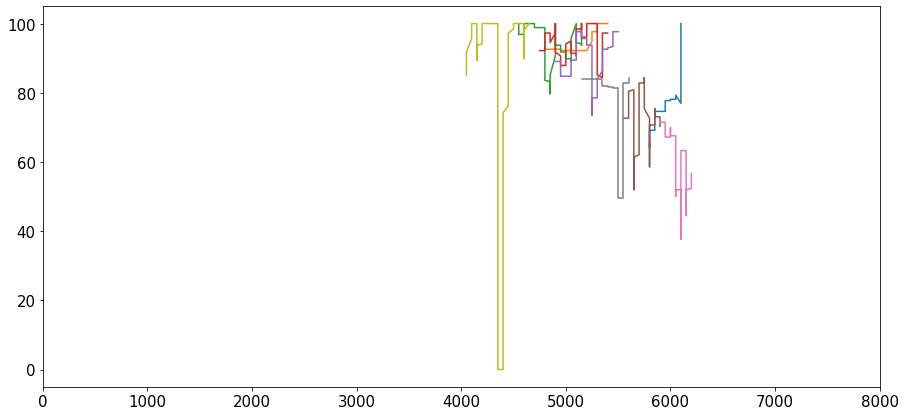

In [65]:
failed_attempts

only_failed_attempts = []

for index, row in failed_attempts.iterrows():
  id = row.user_id
  attempt = row.attempt
  failed_attempt = driving_data[((driving_data.user_id == id) & (driving_data.attempt == attempt))]
  
  only_failed_attempts.append(failed_attempt)
  
  
only_failed_attempts = pd.concat(only_failed_attempts)
only_failed_attempts

# Speed mean
#diff_cope_throttle_1 = average_groups[(average_groups.evis_id == "diff_and_cope1") & (average_groups.attempt == 1)]
#plt.plot(diff_cope_throttle_1.distance_window, diff_cope_mean_1[variable_to_plot], label="Diff & COPE1 Mean Attempt 1")


fig, ax = plt.subplots(figsize=(15,7))
last_500m = only_failed_attempts.groupby(["attempt","evis_id","user_id"]).tail(200)

evis_id = "guess_o_meter"
variable_to_plot = "throttle_position"

diff_cope_throttle_1 = last_500m[(last_500m.evis_id == evis_id) & (last_500m.attempt == 1)]
for index, data in diff_cope_throttle_1.groupby(["user_id"]):
  data[]
  plt.plot(data.distance_window, data[variable_to_plot], label="")
  


plt.xlim(0,8000)

In [66]:
last_500m

,attempt,user_id,evis_id,timestamp,current_soc,energy_consumed,power_usage,range_estimate,speed,distance_traveled,throttle_position,break_position,wheel_rot,xPosition,road_elevation,zPosition,tripMeter,odoMeter,distance_window,seen_range_estimate
4199,1,1,guess_o_meter,439.131200,0.125618,1.080549,9.033869,0.914557,48.163307,5787.54248,65.234840,0.0,0.005371,1212.97000,9.739778,-2223.57400,NaN,NaN,5800,0
4200,1,1,guess_o_meter,439.230774,0.125365,1.080803,9.127105,0.912687,48.155834,5788.88037,65.234840,0.0,0.005890,1213.73743,9.758899,-2224.67017,NaN,NaN,5800,0
4201,1,1,guess_o_meter,439.338623,0.125110,1.081057,9.165066,0.910809,48.148376,5790.21826,65.234840,0.0,0.005921,1214.50366,9.778068,-2225.76660,NaN,NaN,5800,0
4202,1,1,guess_o_meter,439.442535,0.124854,1.081313,9.216682,0.908919,48.150160,5791.55566,66.406750,0.0,0.006470,1215.35352,9.799363,-2226.98486,NaN,NaN,5800,0
4203,1,1,guess_o_meter,439.554474,0.124604,1.081563,9.010071,0.907067,48.164400,5792.74463,66.406750,0.0,0.007111,1216.20200,9.820646,-2228.20557,NaN,NaN,5800,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
523955,2,49,guess_o_meter,674.435059,0.000489,1.206778,5.022903,0.003622,36.874577,7068.24170,20.236823,0.0,-0.000397,1004.04767,8.274640,-3315.38013,135.600662,1905.8335,7050,0
523956,2,49,guess_o_meter,674.535400,0.000392,1.206875,3.467927,0.002908,36.620760,7069.26855,42.458877,0.0,-0.000519,1003.30151,8.260694,-3316.07544,135.600662,1905.8335,7050,0
523957,2,49,guess_o_meter,674.644200,0.000333,1.206934,2.145182,0.002466,36.728280,7070.28800,64.844203,0.0,-0.000549,1002.55695,8.246759,-3316.77000,135.600662,1905.8335,7050,0
523958,2,49,guess_o_meter,674.747500,0.000277,1.206990,2.008720,0.002053,37.090560,7071.19336,80.860317,0.0,-0.000549,1001.72418,8.231140,-3317.54639,135.600662,1905.8335,7050,0
